# Demonstration of Granger causality 
This notebook tests the functionality in causality.py in the brainsignal folder. 
It also uses functionality from the preprocessing.py file. 

In [15]:
# Import libraries and modules.

# Allow display of images.
#from IPython.display import display, Image.

# Import the required modules.
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob

# Add parent folder to path.
import os
import sys
path = os.path.abspath(os.path.join('..'))
sys.path.append(path)

# Tools from brainsignal library.
import brainsignal.datageneration as dg
import brainsignal.datanalysis as da
import brainsignal.preprocessing as pp
import brainsignal.causality as ca

# Make the plots appear inside the notebook.
%matplotlib inline

In [16]:
import brainsignal.causality as ca
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Test with synthetic data
The function ```linear_process_y_to_x.py``` creates a dependent signal where the amount of coupling is userspesified.

We create synthetic data.

In [17]:
# Generate data.

np.random.seed(1) # Setting seed for reproducibility.

# Parameters spantime
duration = 3 # seconds
samplingrate = 200 # Hz
start = 0
spantime = dg.generate_time(duration=duration, samplingrate=samplingrate, start=start)

# Parameters y-series (independent of x-series).
amplitude = 1
frequency = 1
phase = 0
y_series = dg.generate_sinus(spantime, amplitude=amplitude, frequency=frequency, phase=phase)

# Parameters x-series (depenent on y-series).
lam = 0.5 # Coupling 
b_x = 0.8 # Coefficient in x_{t+1} = b_x x_t + \lambda y_t + \epsilon_{x,t}. 
sigma2_x = 0.2 # Noise
x_series = dg.linear_process_y_to_x(y_series, lam=lam, b_x=b_x, sigma2_x=sigma2_x)

Text(0.5, 1.0, 'Synthetic data, x-series (dependent) and y-series (independent)\n    coupling: 0.5, noise (variance): 0.2')

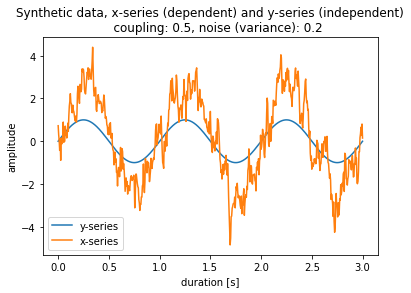

In [18]:
# plotting x-series and y-series
plt.plot(spantime,y_series)
plt.plot(spantime, x_series)
plt.xlabel('duration [s]')
plt.ylabel('amplitude')
plt.legend(['y-series', 'x-series'])
plt.title(f'Synthetic data, x-series (dependent) and y-series (independent)\n\
    coupling: {lam}, noise (variance): {sigma2_x}')

## Checking for stationarity synthetic data
We check the stationarity of the signal 

In [19]:
print(f'p-value for non-stationarity: y-series {ca.stationariy_p_value(y_series)}, x-series {ca.stationariy_p_value(x_series)}')

p-value for non-stationarity: y-series 0.0, x-series 0.13417663344316283


The p-value for the y-series are almost 0, so we can be certain that the signal is stationary.   

The p-value for the x-series is larger than 0.05, so the test is rejected, and we conclude that the x-series is not stationary.

However, the x-series are in fact stationary, which a longer interval would have revield. We demonstrate this: 

In [20]:
# Testing for staionary for the x-series for a 60 second inverval. 

np.random.seed(1) # Setting seed for reproducibility.

# Parameters spantime
duration = 60 # seconds
samplingrate = 200 # Hz
start = 0
spantime = dg.generate_time(duration=duration, samplingrate=samplingrate, start=start)

# Parameters y-series (independent of x-series).
amplitude = 1
frequency = 1
phase = 0
y_series = dg.generate_sinus(spantime, amplitude=amplitude, frequency=frequency, phase=phase)

# Parameters x-series (depenent on y-series).
lam = 0.5 # Coupling 
b_x = 0.8 # Coefficient in x_{t+1} = b_x x_t + \lambda y_t + \epsilon_{x,t}. 
sigma2_x = 0.2 # Noise
x_series = dg.linear_process_y_to_x(y_series, lam=lam, b_x=b_x, sigma2_x=sigma2_x)

print(f'p-value for non-stationarity: y-series {ca.stationariy_p_value(y_series)}, x-series {ca.stationariy_p_value(x_series)}')

p-value for non-stationarity: y-series 0.0, x-series 5.8087813348716135e-30


### Example of non-stationary time-series
An example of a non-stationary time-series is a random walk. 
We demonstrate this:

p-value for non-stationary random walk: 0.3746577908023764


Text(0.5, 1.0, 'Random walk: a non-stationary process')

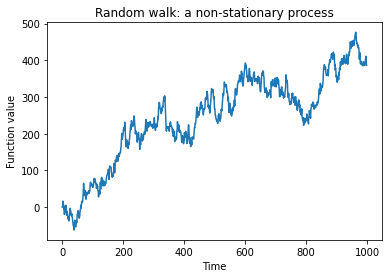

In [21]:
# random walk
np.random.seed(1)
n = 1000
series = np.zeros(n)
series[0] = 0
for i in range(2, n):
    series[i] = series[i-1]+np.random.normal(0,10,1)
print(f'p-value for non-stationary random walk: {ca.stationariy_p_value(series)}')
plt.plot(series)
plt.xlabel('Time')
plt.ylabel('Function value')
plt.title('Random walk: a non-stationary process')

## Finding the best lag
Next is a illustration of the ```aic_lags```-method, which make use of the Var Autoregression tools from the statsmodels-library.

For a time-series $Y_1, Y_2, \ldots Y_t$, we can model $Y_t$ as a function of the earlier components, that is
$$
Y_t = \text{const} + A_1Y_{t-1} + A_2Y_{t-2} + \ldots + A_p Y_{t-p} + \epsilon_t 
.$$
The question is what is the optimal value of $p$ in order to minimiize the residual sum of squares (between the time series values and the linear predictor).
The answer would be to use $p$ as large as possible (more information cannot make the predictive power of the model less). 
However, using the information based criterion AIC, we panalize the number of parameters.  
Thus, we have a tradeoff between the RSS and the number of paramters. 
We obtain:
 

In [22]:
aic_arr = ca.aic_lags(x_series, y_series, maxlag=15)
best_lag = np.argmax(aic_arr)+1
for idx, aic in enumerate(aic_arr):
    print(f'AIC for lag {idx + 1:2}: {aic:>5.1f}')
print(f'Best lag: {best_lag}, AIC for best lag: {np.max(aic_arr):5.1f}')

AIC for lag  1:  -9.4
AIC for lag  2: -64.0
AIC for lag  3: -64.6
AIC for lag  4: -65.3
AIC for lag  5: -65.3
AIC for lag  6: -65.5
AIC for lag  7: -65.6
AIC for lag  8: -65.8
AIC for lag  9: -65.8
AIC for lag 10: -66.0
AIC for lag 11: -66.0
AIC for lag 12: -66.0
AIC for lag 13: -66.1
AIC for lag 14: -66.0
AIC for lag 15: -65.7
Best lag: 1, AIC for best lag:  -9.4


We see that lag 1 is best. 
We have not been able to create a usecase where the optimal lag is not 1, so this is a remaining task.

TODO: Create a test case where we know that the best lag is not 1, and then see that the method returns the right lag.

Text(0.5, 1.0, 'AIC for each lag for y Granger causes x')

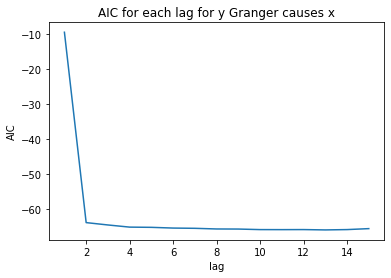

In [23]:
# Plot the AIC values.
plt.plot(range(1, 15+1), aic_arr)
plt.xlabel('lag')
plt.ylabel('AIC')
plt.title('AIC for each lag for y Granger causes x')

As we see, the best lag is 1. 
It seems suspicious that the AIC does not decrase much after lag 1. 

## Test for causality using the Granger causality F-test
We use the Granger causality test frameworks from statsmodels:
https://www.statsmodels.org/dev/vector_ar.html#granger-causality

Performing the Granger causality test on the synthetic data we get: 

In [24]:
l, F, p, gc_dict = ca.gc_values(x_series, y_series, maxlag=best_lag, return_dict=True)
print(f'For the best lag: {l}, the F-stiatic for y not Granger causing x is: {F:5.2f}.')
print(f'The corresponding p-value is: {p:5.2f}.')

For the best lag: 1, the F-stiatic for y not Granger causing x is: 1313.96.
The corresponding p-value is:  0.00.


### Granger causality for different coupling strengths $\lambda$'s

Next we find the p-value for the Granger causality test with different coupling strengths.
We create different depending time-series with different about of coupling. 

Coupling: 0.0, F-statistic:   0.5, p-value: 4.7e-01
Coupling: 0.1, F-statistic:  23.3, p-value: 5.2e-06
Coupling: 0.2, F-statistic:  32.5, p-value: 1.3e-07
Coupling: 0.3, F-statistic:  60.6, p-value: 7.7e-12
Coupling: 0.4, F-statistic:  65.8, p-value: 1.5e-12
Coupling: 0.5, F-statistic: 101.2, p-value: 1.0e-16
Coupling: 0.6, F-statistic: 113.8, p-value: 4.9e-18
Coupling: 0.7, F-statistic: 175.4, p-value: 1.8e-23
Coupling: 0.8, F-statistic: 327.2, p-value: 7.7e-33
Coupling: 0.9, F-statistic: 348.7, p-value: 6.9e-34
Coupling: 1.0, F-statistic: 421.1, p-value: 4.6e-37


Text(0, 0.5, 'Log p-value')

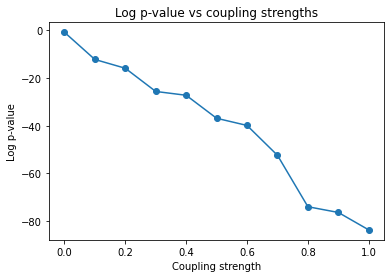

In [25]:
## Comparing GC score for different coupling values
spantime = dg.generate_time(duration=10,samplingrate=10,start=0)
y_series = dg.generate_sinus(spantime,amplitude=1,frequency=0.1,phase=0)
lambdas = 0.1*np.arange(10+1)
p_values = []
for l in lambdas:
    x_series = dg.linear_process_y_to_x(y_series, lam=l,b_x=0.8, sigma2_x=0.01)
    _, F, p_value = ca.gc_values(x_series,y_series, maxlag=4)
    print(f"Coupling: {l:.1f}, F-statistic: {F:5.1f}, p-value: {p_value:.1e}")
    p_values.append(p_value)
p_log_values = [np.log(p) for p in p_values]
plt.plot(lambdas, p_log_values, '-o')
plt.title("Log p-value vs coupling strengths")
plt.xlabel("Coupling strength")
plt.ylabel("Log p-value")

When we do not have any coupling, the p-valus is 0.9, so we accept the null-hypothesis and conclude that $y$ does not Granger causes x.

From 0.1 to 1 in coupling, the test is rejected and we accapt that y Granger causes x. 

The p-value has a log-linear downward trend.

# Investigating the real data

In [26]:
rep = '../data/'
patientdir = 'PatID 2_Txt Files'
file = glob.glob(rep + patientdir+'/WAVE_ICP*.txt', recursive=True)[0]
data = pd.read_csv(file, header=None, decimal=',', delimiter=';')
data_array_ICP = np.array(data.values)
ICP_signal = data_array_ICP.transpose()[0]


file = glob.glob(rep + patientdir+'/WAVE_ABP*.txt', recursive=True)[0]
data = pd.read_csv(file,header=None, decimal=',', delimiter=';')
data_array_ABP = np.array(data.values)
ABP_signal = data_array_ABP.transpose()[0]


fs = 200
spantime = np.arange(len(ICP_signal))/fs
#ICP_time = np.arange(len(ICP_signal))/fs
#ABP_time = np.arange(len(ABP_signal))/fs

### Calculating stationarity p-values and Granger causality statistics 

Interval seconds: 0.1
p-value ABP stationarity:  1.00e+00
p-value ICP stationarity:  1.00e+00
p-value ABP Granger causes ICP: 1.24e-03
Best lag: 1

Interval seconds: 1
p-value ABP stationarity:  7.19e-04
p-value ICP stationarity:  3.20e-01
p-value ABP Granger causes ICP: 1.72e-08
Best lag: 1

Interval seconds: 5
p-value ABP stationarity:  8.96e-11
p-value ICP stationarity:  1.34e-08
p-value ABP Granger causes ICP: 1.85e-35
Best lag: 1

Interval seconds: 10
p-value ABP stationarity:  7.79e-13
p-value ICP stationarity:  4.65e-15
p-value ABP Granger causes ICP: 5.12e-70
Best lag: 1

Interval seconds: 30
p-value ABP stationarity:  3.66e-23
p-value ICP stationarity:  2.33e-18
p-value ABP Granger causes ICP: 1.57e-146
Best lag: 1

Interval seconds: 60
p-value ABP stationarity:  0.00e+00
p-value ICP stationarity:  2.50e-23
p-value ABP Granger causes ICP: 0.00e+00
Best lag: 1



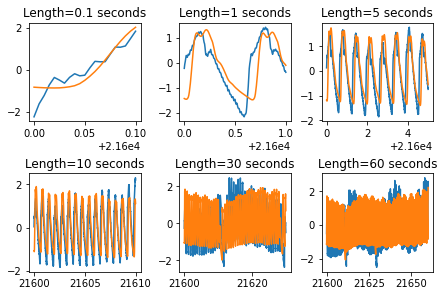

In [27]:
time = 6 # hours
seconds = [0.1, 1, 5, 10, 30, 60]
fig, ax = plt.subplots(2,3, constrained_layout = True)
coor_h = [0, 0, 0, 1, 1, 1]
coor_v = [0, 1, 2, 0, 1, 2]
for sec, v, h in zip(seconds, coor_v, coor_h):
    indices = da.indexseq(time*60*60, sec, spantime)
    x = pp.standardize(ICP_signal[indices]) # effect
    y = pp.standardize(ABP_signal[indices]) # cause
    p_value_stationarity_ICP = ca.stationariy_p_value(x)
    p_value_stationarity_ABP = ca.stationariy_p_value(y)
    best_lag, F, p_value_gc = ca.gc_values(x, y)
    ax[h, v].plot(spantime[indices], x)
    ax[h, v].plot(spantime[indices], y)
    ax[h, v].set_title(f"Length={sec} seconds")
    print(f"Interval seconds: {sec}")
    print(f"p-value ABP stationarity: {p_value_stationarity_ABP: .2e}")
    print(f"p-value ICP stationarity: {p_value_stationarity_ICP: .2e}")
    print(f"p-value ABP Granger causes ICP: {p_value_gc:.2e}")
    print(f"Best lag: {best_lag}\n")

For 0.1 second the signals are not stationary. 
From 1 second the stationarity p-values of the signal increase when the duration of the signal increase. 

For the p-value of test of Granger causality from ABP to ICP, it increase with the length of the time window.

This gives an idea of potential pitfall when testing on the data. 

If we test the compling between the signal with a window size of longer than around 1 seconds, we are likely to get a very small p-value. 
Thus, it may be a good idea to shorten the length of the signal. 

In the notebook ```causality_patients.ipynb``` we have tried out different combinations of window-sizes and reampling frequencies for the data for a patient from a whole night. 

## Checking how the frequency affects the Granger causality statistic.
We consider a one second interval and resample the signal with different frequencies. 

We are interested in how much we can lower the frequency and still have significant Granger causality from ABP to ICP.

Resampled frequency: 200, Stationarity ABP: 6.10e-02 Stationarity ICP 6.18e-02, ABP Granger causes ICP p-value: 4.15e-16
Resampled frequency: 150, Stationarity ABP: 1.61e-01 Stationarity ICP 5.23e-02, ABP Granger causes ICP p-value: 3.92e-12
Resampled frequency: 100, Stationarity ABP: 1.89e-03 Stationarity ICP 3.21e-03, ABP Granger causes ICP p-value: 3.44e-08
Resampled frequency:  50, Stationarity ABP: 4.53e-02 Stationarity ICP 1.84e-02, ABP Granger causes ICP p-value: 2.70e-04
Resampled frequency:  30, Stationarity ABP: 2.22e-03 Stationarity ICP 2.45e-02, ABP Granger causes ICP p-value: 7.41e-03
Resampled frequency:  20, Stationarity ABP: 8.93e-02 Stationarity ICP 8.81e-03, ABP Granger causes ICP p-value: 1.59e-02


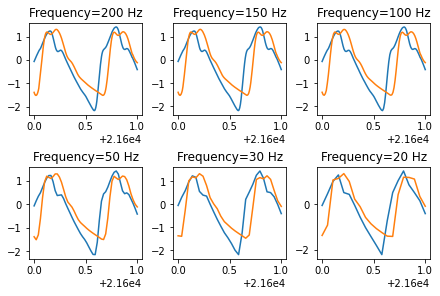

In [28]:
time = 6 # hours
frequencies = [200, 150, 100, 50, 30, 20]
fig, ax = plt.subplots(2,3, constrained_layout = True)
coor_h = [0, 0, 0, 1, 1, 1]
coor_v = [0, 1, 2, 0, 1, 2]
sec = 1 # consider 1 second interval
for fs, v, h in zip(frequencies, coor_v, coor_h):
    indices = da.indexseq(time*60*60, sec, spantime)
    new_spantime = np.linspace(time*60*60, time*60*60+sec, fs)
    new_ABP = pp.resampling(spantime[indices], ABP_signal[indices], new_spantime, window_length_time=0.1, polyorder=2)
    new_ICP = pp.resampling(spantime[indices], ICP_signal[indices], new_spantime, window_length_time=0.1, polyorder=2)
    x = pp.standardize(new_ICP)
    y = pp.standardize(new_ABP)
    p_value_stationarity_ICP = ca.stationariy_p_value(x)
    p_value_stationarity_ABP = ca.stationariy_p_value(y)
    best_lag, F, p_value_gc = ca.gc_values(x, y)
    ax[h, v].plot(new_spantime, x)
    ax[h, v].plot(new_spantime, y)
    ax[h, v].set_title(f"Frequency={fs} Hz")
    print(f"Resampled frequency: {fs:3}, Stationarity ABP: {p_value_stationarity_ABP:.2e} Stationarity ICP {p_value_stationarity_ICP:.2e}, ABP Granger causes ICP p-value: {p_value_gc:.2e}")

We see that both ABP and ICP remain stationary when lower the frequency all the way down from 200 to 20 Hz. 

We also se that ABP Granger causes ICP for all frequencies. 
However, we also see that the p-value decrease when lowering the frequency. 
Still, even for 20 Hz the Granger causalty is significant. 

When calculating the Granger causality from ABP to ICP through a whole day of measurement, it is usefull to know that we may lowering the frequency for efficiency. 